## Neural Networks 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

tf.get_logger().setLevel('ERROR')

import keras_tuner as kt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import StandardScaler

2025-05-04 15:46:56.208941: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Neural Networks

In [2]:
def run_keras_tuner(X_dict, y_dict, 
                    n_splits=5, 
                    max_trials=10, 
                    executions_per_trial=1,
                    epochs=60, 
                    batch_size=16,
                    random_state=42):
    """
    Run Keras Tuner hyperparameter search with K-Fold cross-validation
    over multiple feature sets.

    Parameters:
    -----------
    X_dict : dict[str, np.ndarray]
        Dictionary mapping feature-set names to feature matrices of shape (n_samples, n_features).
    y : np.ndarray
        Label vector of shape (n_samples,).
    n_splits : int
        Number of folds for K-Fold CV.
    max_trials : int
        Number of hyperparameter trials per fold.
    executions_per_trial : int
        Number of model builds per trial.
    epochs : int
        Maximum number of epochs for training.
    batch_size : int
        Batch size for training.
    random_state : int
        Seed for reproducibility in KFold splitting.

    Returns:
    --------
    results : dict
        For each feature-set name, returns a dict with:
          - "cv_scores": list of fold accuracies
          - "mean_acc": mean accuracy across folds
          - "std_acc": std of accuracies
          - "best_model": retrained model on full data with best hyperparameters
          - "best_hps": HyperParameters object of the best trial from the last fold
          - "histories": list of training History objects (one per fold)
    """
    results = {}

    # Prepare cross-validator
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for name, X in X_dict.items():
        print(f"\n=== Feature set: {name} ===")
        fold_scores = []
        histories = []
        models = []
        best_hps_last = None

        y = y_dict[name]
        num_classes = len(np.unique(y))

        # Iterate folds
        for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
            print(f"\n-- Fold {fold}/{n_splits} --")
            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr, y_val = y[train_idx], y[val_idx]
            # One-hot encode
            y_tr_ohe = tf.keras.utils.to_categorical(y_tr, num_classes)
            y_val_ohe = tf.keras.utils.to_categorical(y_val, num_classes)

            # Early stopping
            early_stop = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            )

            # Model builder for tuner
            def model_builder(hp):
                model = tf.keras.Sequential()
                model.add(tf.keras.layers.Input(shape=(X_tr.shape[1],)))

                # Dense layer
                units1 = hp.Int('units_1', 32, 128, step=32)
                model.add(tf.keras.layers.Dense(units1, kernel_initializer='he_normal'))
                model.add(tf.keras.layers.BatchNormalization())
                model.add(tf.keras.layers.Activation('relu'))

                # Optional second layer
                if hp.Boolean('add_second_layer'):
                    units2 = hp.Int('units_2', 32, 64, step=16)
                    model.add(tf.keras.layers.Dense(units2, kernel_initializer='he_normal'))
                    model.add(tf.keras.layers.BatchNormalization())
                    model.add(tf.keras.layers.Activation('relu'))

                # Dropout
                dropout = hp.Float('dropout', 0.2, 0.4, step=0.1)
                model.add(tf.keras.layers.Dropout(dropout))

                # Output
                model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

                # Optimizer
                lr = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])
                model.compile(
                    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )
                return model

            # Initialize tuner
            tuner = kt.RandomSearch(
                model_builder,
                objective='val_accuracy',
                max_trials=max_trials,
                executions_per_trial=executions_per_trial,
                directory='keras_tuner_dir',
                project_name=f'{name}_fold{fold}'
            )

            # Hyperparameter search on this fold
            tuner.search(
                X_tr, y_tr_ohe,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(X_val, y_val_ohe),
                callbacks=[early_stop],
                verbose=2
            )

            # Get best hyperparameters for this fold
            best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
            best_hps_last = best_hps  # keep last to retrain on full data later

            # Build and train best model on this fold
            model = tuner.hypermodel.build(best_hps)
            history = model.fit(
                X_tr, y_tr_ohe,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(X_val, y_val_ohe),
                callbacks=[early_stop],
                verbose=0
            )
            histories.append(history)
            models.append(model)

            # Evaluate on validation split
            val_preds = model.predict(X_val)
            val_labels = np.argmax(val_preds, axis=1)
            acc = accuracy_score(y_val, val_labels)
            print(f"Fold {fold} accuracy: {acc:.4f}")
            fold_scores.append(acc)

        # Summarize CV results
        mean_acc = np.mean(fold_scores)
        std_acc = np.std(fold_scores)
        print(f"\n{name} — CV mean acc: {mean_acc:.4f} ± {std_acc:.4f}")

        # Retrain best model on full dataset
        y_ohe_full = tf.keras.utils.to_categorical(y, num_classes)
        final_model = tuner.hypermodel.build(best_hps_last)
        final_history = final_model.fit(
            X, y_ohe_full,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=[early_stop],
            verbose=0
        )

        results[name] = {
            "cv_scores": fold_scores,
            "mean_acc": mean_acc,
            "std_acc": std_acc,
            "best_model": final_model,
            "best_hps": best_hps_last,
            "histories": histories,
            "models": models,
            "final_history": final_history,
            "X": X,
            "y": y_ohe_full
        }

    return results

In [3]:
# Load datasets and join them
def load_dataset(*paths):
    base_dir = Path("../datasets")
    if len(paths) == 1:
        return np.load(base_dir / paths[0])
    else:
        return np.concatenate([np.load(base_dir / path) for path in paths], axis=0)

In [4]:
X_original = pd.read_csv("../datasets/ACDC_radiomics.csv")
X_original.drop(columns=["class"], inplace=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)

In [5]:
# Feature sets and label vector
feature_sets = {
    'Baseline': X_scaled,
    'PCA': load_dataset('X_pca_16.npy'),
    # 'tSNE': load_dataset('X_t-SNE.npy'),
    'LDA': load_dataset('X_train_lda.npy', 'X_test_lda.npy'),
    # 'KPCA': load_dataset('X_train_kpca.npy', 'X_test_kpca.npy'),
    'FS': load_dataset('X_feature_select.npy')
}

y_sets = {
    'Baseline': load_dataset('y_enc.npy'),
    'PCA': load_dataset('y_enc.npy'),
    # 'tSNE': load_dataset('y_enc.npy'),
    'LDA': load_dataset('y_train_lda.npy', 'y_test_lda.npy'),
    # 'KPCA': load_dataset('y_enc.npy'),
    'FS': load_dataset('y_enc.npy')
}

y = load_dataset('y_enc.npy')

results = run_keras_tuner(feature_sets, y_sets, n_splits=5)

# Access to the results:
for key, value in feature_sets.items():
    print(results[key]['mean_acc'], results[key]['std_acc'])
    best_model = results[key]['best_model']

Trial 10 Complete [00h 00m 04s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.6000000238418579
Total elapsed time: 00h 00m 33s
1/1 [==============================] - 0s 45ms/step
Fold 5 accuracy: 0.5500

FS — CV mean acc: 0.4700 ± 0.1364
0.6799999999999999 0.2135415650406262
0.5900000000000001 0.23108440016582688
0.9 0.10488088481701517
0.47000000000000003 0.13638181696985857


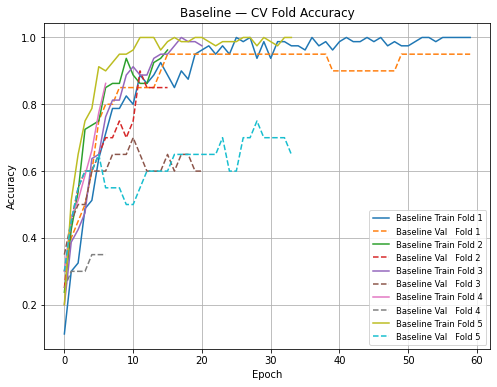

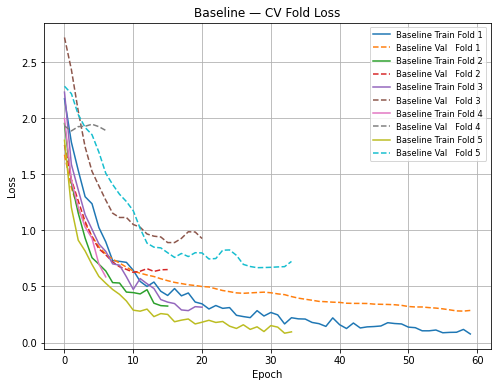

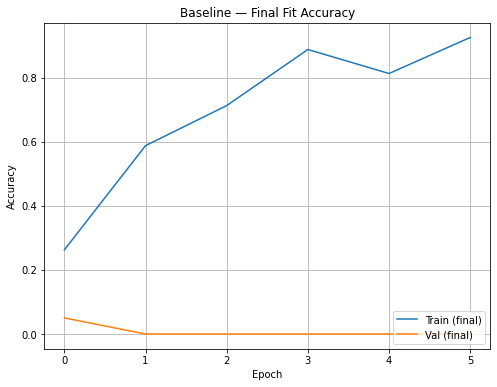

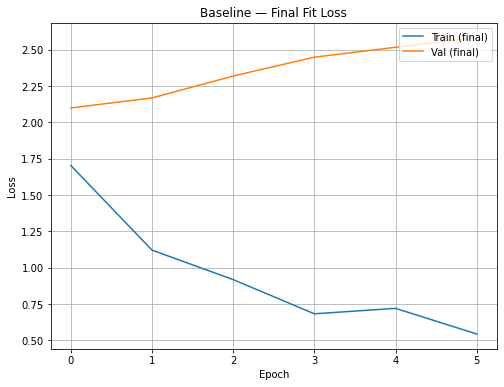

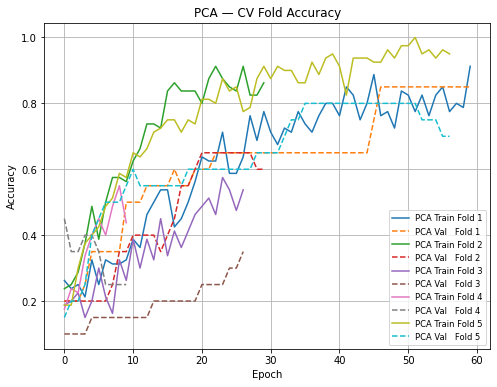

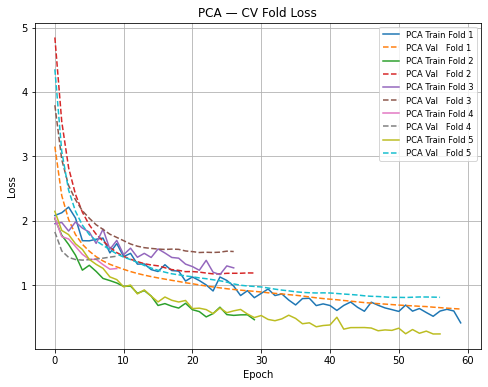

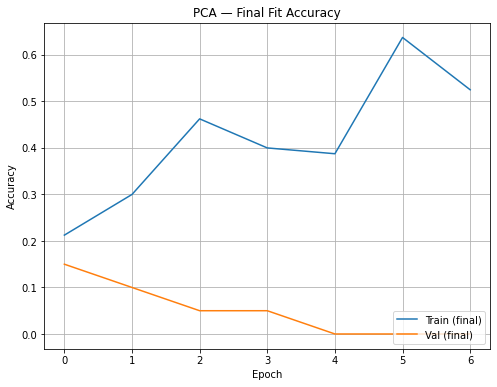

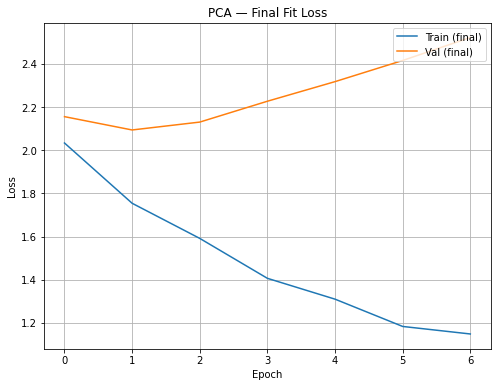

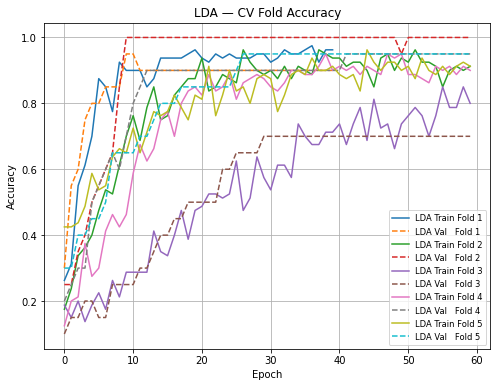

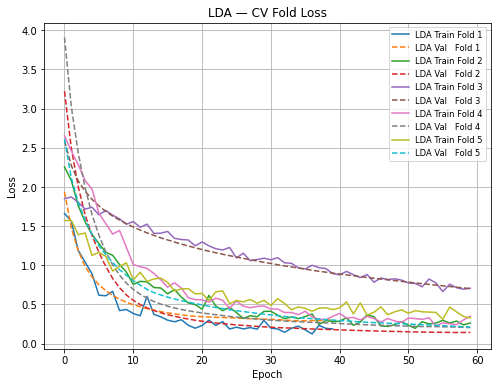

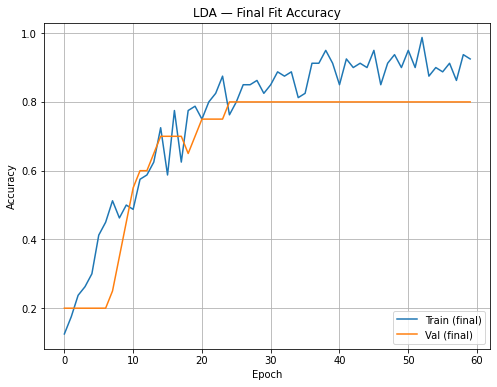

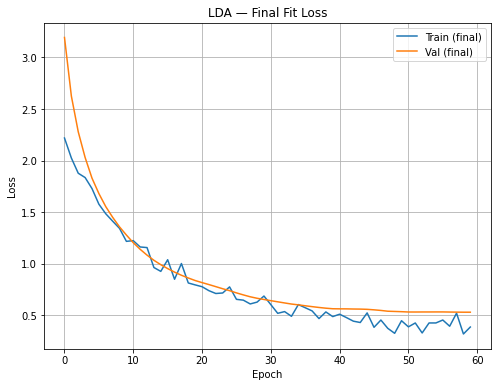

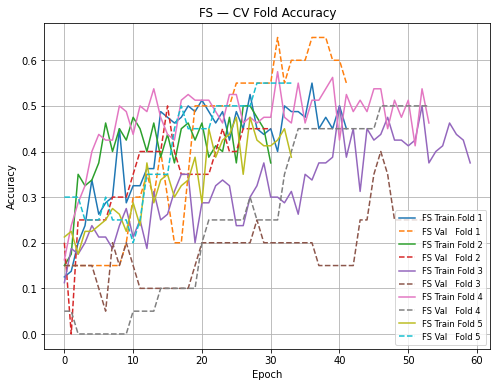

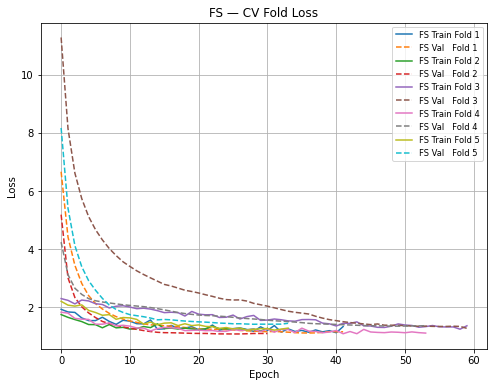

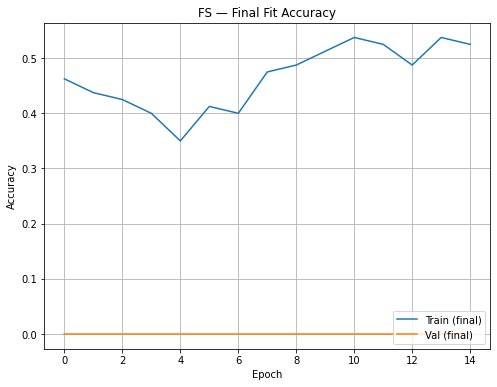

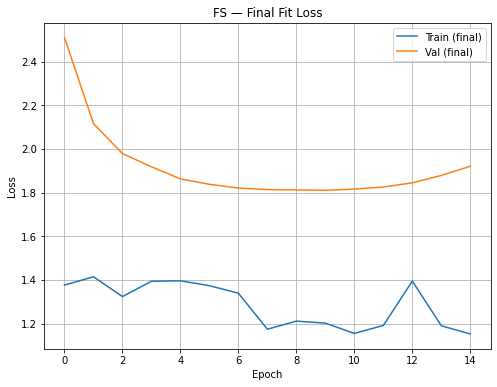

In [6]:
for name, res in results.items():
    histories = res['histories']        # list of History objs, one per fold
    final_history = res['final_history']

    # 1) Plot CV-fold training & validation accuracy
    plt.figure(figsize=(8, 6))
    for fold, h in enumerate(histories, start=1):
        plt.plot(h.history['accuracy'],             label=f'{name} Train Fold {fold}')
        plt.plot(h.history['val_accuracy'], linestyle='--', label=f'{name} Val   Fold {fold}')
    plt.title(f'{name} — CV Fold Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.show()

    # 2) Plot CV-fold training & validation loss
    plt.figure(figsize=(8, 6))
    for fold, h in enumerate(histories, start=1):
        plt.plot(h.history['loss'],             label=f'{name} Train Fold {fold}')
        plt.plot(h.history['val_loss'], linestyle='--', label=f'{name} Val   Fold {fold}')
    plt.title(f'{name} — CV Fold Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True)
    plt.show()

    # 3) Plot final-fit training accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(final_history.history['accuracy'], label='Train (final)')
    if 'val_accuracy' in final_history.history:
        plt.plot(final_history.history['val_accuracy'], label='Val (final)')
    plt.title(f'{name} — Final Fit Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # 4) Plot final-fit training loss
    plt.figure(figsize=(8, 6))
    plt.plot(final_history.history['loss'], label='Train (final)')
    if 'val_loss' in final_history.history:
        plt.plot(final_history.history['val_loss'], label='Val (final)')
    plt.title(f'{name} — Final Fit Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()


4/4 [==============================] - 0s 1ms/step


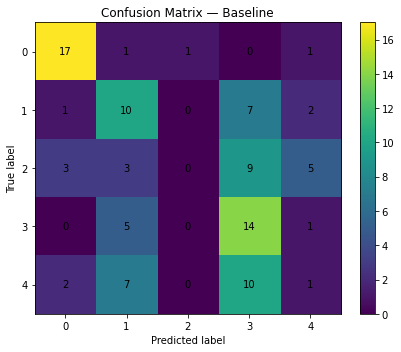

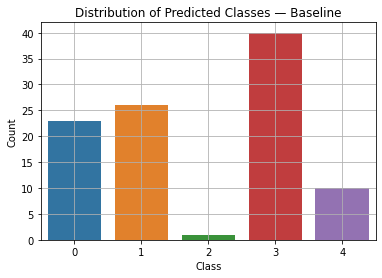

4/4 [==============================] - 0s 2ms/step


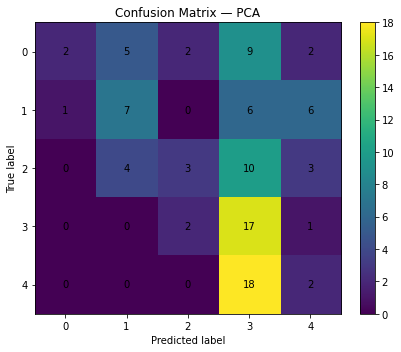

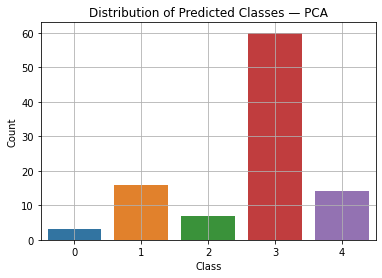

4/4 [==============================] - 0s 1ms/step


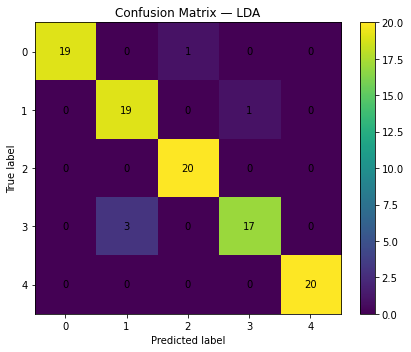

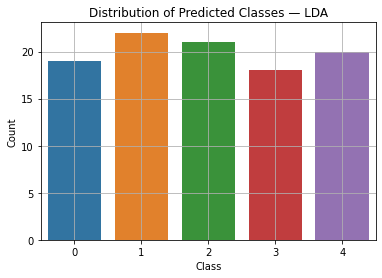

4/4 [==============================] - 0s 1ms/step


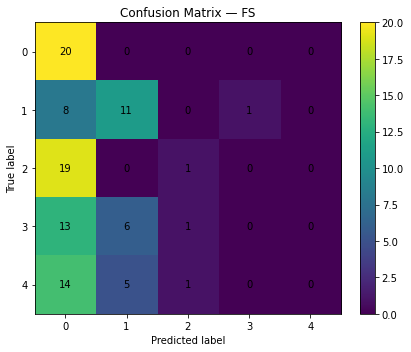

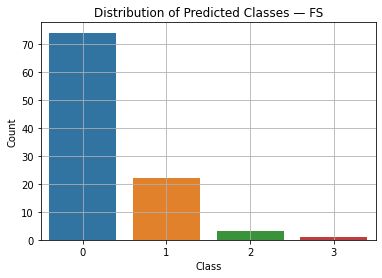

In [7]:
for name, res in results.items():
    model = res['best_model']
    X_full = feature_sets[name]
    y_full = y_sets[name]
    
    # Predict and turn probabilities into class labels
    y_pred_proba = model.predict(X_full)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Compute confusion matrix

    cm = confusion_matrix(y_full, y_pred)
    
    # Plot
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', aspect='auto')
    plt.title(f'Confusion Matrix — {name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    
    # Annotate counts in cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

    # Distribution of predicted classes
    sns.countplot(x=y_pred)
    plt.title(f'Distribution of Predicted Classes — {name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()


In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Build comparison metrics table
metrics = []
for name, res in results.items():
    # Cross-validated metrics
    mean_cv = res['mean_acc']
    std_cv = res['std_acc']
    
    # Final model accuracy on full dataset via confusion matrix
    y_pred = np.argmax(res['best_model'].predict(res['X']), axis=1)
    cm = confusion_matrix(y, y_pred)
    final_acc = cm.diagonal().sum() / cm.sum()
    
    metrics.append({
        'feature_set': name,
        'mean_cv_accuracy': mean_cv,
        'std_cv_accuracy': std_cv,
        'final_accuracy': final_acc
    })

df = pd.DataFrame(metrics).set_index('feature_set')

# Display the table to the user
df


4/4 [==============================] - 0s 1ms/step


,mean_cv_accuracy,std_cv_accuracy,final_accuracy
feature_set,,,
Baseline,0.68,0.213542,0.42
PCA,0.59,0.231084,0.31
LDA,0.90,0.104881,0.22
FS,0.47,0.136382,0.32


1/1 [==============================] - 0s 36ms/step


/home/juan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/juan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


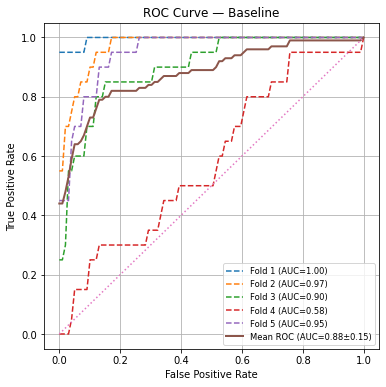

1/1 [==============================] - 0s 38ms/step


/home/juan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/juan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


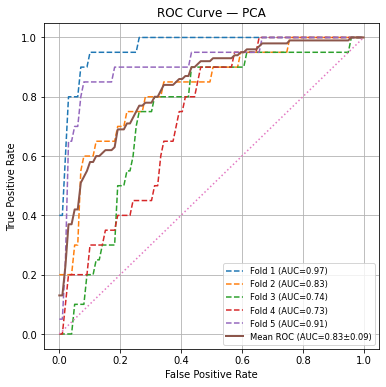

1/1 [==============================] - 0s 39ms/step


/home/juan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


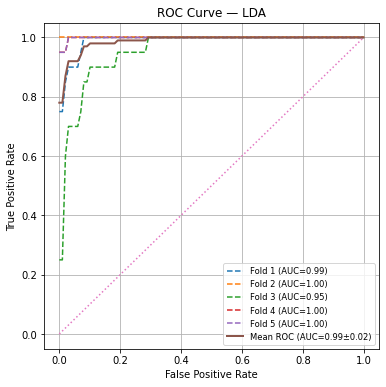

1/1 [==============================] - 0s 31ms/step


/home/juan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/juan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/juan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 20ms/step


/home/juan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/juan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/juan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


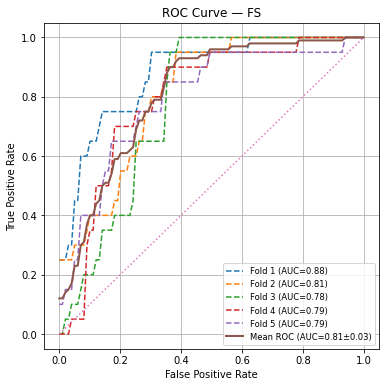

,method,fold,accuracy,precision_macro,recall_macro,f1_macro,roc_auc_macro
0,Baseline,1,0.95,0.966667,0.933333,0.941818,0.995625
1,Baseline,2,0.75,0.776667,0.753333,0.745397,0.971875
2,Baseline,3,0.65,0.621429,0.538095,0.571429,0.900000
3,Baseline,4,0.30,0.235714,0.210000,0.220588,0.582500
4,Baseline,5,0.75,0.746667,0.733333,0.691255,0.948750
5,PCA,1,0.85,0.870000,0.870000,0.848413,0.968125
6,PCA,2,0.65,0.733333,0.653333,0.656667,0.827500
7,PCA,3,0.25,0.266667,0.190476,0.213333,0.739375
8,PCA,4,0.40,0.177143,0.220000,0.192727,0.726875
9,PCA,5,0.80,0.783333,0.810000,0.787778,0.911875


In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_curve, auc
)
import matplotlib.pyplot as plt

# Prepare storage for overall CV metrics
cv_metrics = []
cv_metrics_fold = []

# Common fpr grid for interpolation
mean_fpr = np.linspace(0, 1, 100)

for name, res in results.items():
    X = res['X']
    y_ohe = res['y']
    y_true = np.argmax(y_ohe, axis=1)
    models = res['models']

    # Lists to collect per-fold metrics
    accs, precs, recs, f1s, aucs = [], [], [], [], []
    tprs = []

    n_splits = len(models)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Iterate each fold and its model
    fold = 1
    for (train_idx, val_idx), model in zip(kf.split(X, y_true), models):
        X_val = X[val_idx]
        y_val_true = y_true[val_idx]
        y_val_ohe = y_ohe[val_idx]

        # Predict probabilities and labels
        y_pred_proba = model.predict(X_val)
        y_pred_labels = np.argmax(y_pred_proba, axis=1)

        # Compute classification metrics
        accs.append(accuracy_score(y_val_true, y_pred_labels))
        precs.append(precision_score(y_val_true, y_pred_labels, average='macro'))
        recs.append(recall_score(y_val_true, y_pred_labels, average='macro'))
        f1s.append(f1_score(y_val_true, y_pred_labels, average='macro'))

        # Compute micro-average ROC curve & AUC
        fpr, tpr, _ = roc_curve(y_val_ohe.ravel(), y_pred_proba.ravel())
        aucs.append(auc(fpr, tpr))
        # Interpolate tpr onto the common fpr grid
        tprs.append(np.interp(mean_fpr, fpr, tpr))

        # Aggregate metrics
        cv_metrics_fold.append({
            'method': name,
            'fold': fold,
            'accuracy': accs[-1],
            'precision_macro': precs[-1],
            'recall_macro': recs[-1],
            'f1_macro': f1s[-1],
            'roc_auc_macro': aucs[-1]
        })
        fold += 1

    # Aggregate metrics
    cv_metrics.append({
        'feature_set': name,
        'accuracy_mean': np.mean(accs),
        'accuracy_std': np.std(accs),
        'precision_mean': np.mean(precs),
        'precision_std': np.std(precs),
        'recall_mean': np.mean(recs),
        'recall_std': np.std(recs),
        'f1_mean': np.mean(f1s),
        'f1_std': np.std(f1s),
        'roc_auc_mean': np.mean(aucs),
        'roc_auc_std': np.std(aucs),
    })

    # Plot ROC curves for this feature set
    plt.figure(figsize=(6, 6))
    for i, tpr in enumerate(tprs, 1):
        plt.plot(mean_fpr, tpr, linestyle='--', label=f'Fold {i} (AUC={aucs[i-1]:.2f})')
    # Mean ROC
    mean_tpr = np.mean(tprs, axis=0)
    plt.plot(mean_fpr, mean_tpr, linewidth=2,
             label=f'Mean ROC (AUC={np.mean(aucs):.2f}±{np.std(aucs):.2f})')
    plt.plot([0, 1], [0, 1], linestyle=':')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve — {name}')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.show()

# Display a comparison table of the metrics
df_metrics = pd.DataFrame(cv_metrics_fold)
df_metrics.round(3)

df_metrics.to_csv('nn_comparison_metrics.csv', index=False)
display(df_metrics)
